# Joint Training models for NER + Intent Classification



### Load the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import json
from sklearn.model_selection import train_test_split
import spacy


In [2]:

class JsonData():
    """
    Class for json data. Can be a subclass with an abstract call of Dataset
    if there are more ways of ingesting data.
    Json structure required is
        {
          "name": "ChatSample",
          "lang": "en",
          "sentences": [
            {
              "text": "i want to go marienplatz",
              "intent": "FindConnection",
              "entities": [
                {
                  "entity": "StationDest",
                  "start": 4,
                  "stop": 4,
                  "text": "marienplatz"
                }
              ],
              "training": false
            },...
        }
    """
    def __init__(self,json_path,lang):
        self.json_path = json_path
        self.lang = lang
    def load_data(self):
        '''
        loading can be chunked for bigger files
        '''
        try:
            data = json.load(open(self.json_path,"r"))
        except FileNotFoundError:
            print("Wrong file or file path")
        return data
    def parse_data(self,data):
        '''
        parse data for all labels. intents and entity labels
        '''
        check_keys(data,['lang','sentences'])
        if data['lang'] != self.lang:
            print('Required language {0} not present in file'.format(self.lang))
            raise ValueError('Required language {0} not present in file'.format(self.lang))       
        if len(data['sentences']) == 0:
            print('Json file has no sentences')
            raise ValueError('Json file has no sentences')
        sents = [each['text'] for each in data['sentences']]
        print("{0} sentences found".format(str(len(sents))))
        intent_labels = [each['intent'] for each in data['sentences']]
        entity_labels = [each['entities'] for each in data['sentences']]
        return sents,intent_labels,entity_labels
    def get_data(self):
        '''
        All functions need to just call this function to get data either at one-shot or in chunks
        Can implement chunking with a generator here if needed for bigger files
        '''
        data = self.load_data()
        sentences_,intents_, entities_ = self.parse_data(data)
        return sentences_, intents_,entities_



In [39]:
json_data = JsonData("ChatbotCorpus.json","en")
sentences, intents,entities = json_data.get_data()
intent_pd = pd.DataFrame({'sent':sentences,'intent':intents})

206 sentences found


## Task - NER

Converting the entity data to the format required for spacy ner training

In [51]:
from spacy.attrs import ORTH

nlp = spacy.load("en_core_web_md")

def generate_ner_train_annot(sentences,entities,intents):
    '''
    Generating the ner data in required format for spacy
    '''
    print("Starting spacy ner annotations..")
    case = [{ORTH: "what"}, {ORTH: "'"},{'ORTH':'s'}]
    nlp.tokenizer.add_special_case("what's", case)
    unq_intents = list(set(intents))    
    data_annotated = []
    for i,sent in enumerate(sentences):
        doc = nlp(sent)
        tokens = [(token.text,token.idx) for token in doc]
        label_intent = {label:False for label in unq_intents}
        entities_list = []
        for ent_tag in entities[i]:
            start_char = tokens[int(ent_tag['start'])][1]
            end_char = tokens[int(ent_tag['stop'])][1] + len(tokens[int(ent_tag['stop'])][0])
            if not sentences[i][start_char:end_char] == ent_tag['text']:
                logger.info("Entity tagged text not matching with position")
                logger.info("i: {0},sentence: {1},ent_tag: {2}".format(str(i),
                    str(sentences[i]),str(ent_tag)))
            else:
                entities_list.append((start_char,end_char,ent_tag['entity']))
        intent = intents[i]
        label_intent[intent] = True
        sent_entities = (sentences[i],{"entities":entities_list},label_intent)
        data_annotated.append(sent_entities)
    print("Spacy annotations done for {} sentences".format(len(sentences)))
    return data_annotated

In [52]:
spacy_annot_data = generate_ner_train_annot(sentences,entities,intents)

Starting spacy ner annotations..
Spacy annotations done for 206 sentences


In [53]:
spacy_annot_data[:2]

[('i want to go marienplatz',
  {'entities': [(13, 24, 'StationDest')]},
  {'DepartureTime': False, 'FindConnection': True}),
 ('when is the next train in muncher freiheit?',
  {'entities': [(17, 22, 'Vehicle'),
    (12, 16, 'Criterion'),
    (26, 42, 'StationStart')]},
  {'DepartureTime': True, 'FindConnection': False})]

**Splitting into train and test**

In [54]:
sentences_train,sentences_test,spacy_train_data,spacy_test_data = train_test_split(sentences,spacy_annot_data,test_size=0.2,random_state =42)

# NER + Intent Training

In [150]:
'''
Modules for NER tagging
'''
# pylint: disable=no-member

import sys
import random
import warnings
import yaml
import spacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from spacy.util import minibatch, compounding


def spacy_model_with_ner_textcat(model=None):
    '''
    creates the spacy model.
    '''
    custom_nlp = spacy.blank('en')
    ner = custom_nlp.create_pipe('ner')
    custom_nlp.add_pipe(ner)
    textcat = custom_nlp.create_pipe('textcat',config={"exclusive_classes": True})
    custom_nlp.add_pipe(textcat)    
    return custom_nlp,ner,textcat

def add_entities_ner(annot_data,ner):
    '''
    Adds entities from annotation data to ner
    '''
    for _, annotations,cats in annot_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
    return ner

def add_labels_textcat(labels,textcat):
    '''
    Adds labels from text classification data to textcat
    '''
    for label in labels:
        textcat.add_label(label)
    return textcat

def train_joint_model(custom_nlp,spacy_train_data,n_iter):
    '''
    Train spacy ner models
    '''
    pipe_exceptions = ["ner","textcat", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in custom_nlp.pipe_names if pipe not in pipe_exceptions]

    tot_loss = []

    with custom_nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
        warnings.filterwarnings("once", category=UserWarning, module='spacy')
#         optimizer = nlp.begin_training(get_gold_tuples=lambda: spacy_train_data)
        custom_nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(spacy_train_data)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(spacy_train_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations,cats = zip(*batch)
                golds = [GoldParse(nlp.make_doc(text),entities=annotation['entities'],cats=cat) for text,annotation,cat in batch]
                custom_nlp.update(
                    texts,
                    golds,
                    drop=0.5,
                    losses=losses,
#                     sgd=optimizer
                )
            tot_loss.append(losses)
            print("Losses {0} at iteration {1}".format(str(losses),str(itn)))
    return custom_nlp,tot_loss



def save_ner_model(custom_nlp,model_path):
    '''
    saves a ner model as per config params
    '''
    try:
        custom_nlp.to_disk(model_path)
        print("Ner model saved to {}".format(cfg['NER_MODEL_PATH']))
    except Exception as err:
        print(("Error '{0}' occured. Arguments {1}.".format(err)))

def load_ner_model(model_path):
    '''
    loads a ner model as per config params
    '''
    custom_nlp = None
    try:
        custom_nlp = spacy.load(model_path)
    except Exception as err:
        print(("Error '{0}' occured. Arguments {1}.".format(err)))
    return custom_nlp

def evaluate_ner(ner_model, examples):
    '''
    evaluates an ner model
    '''
    scorer = Scorer()
    for input_, annot,cat in examples:
        doc_gold_text = ner_model.make_doc(input_)
#         for key, value in cat.items():            
#             cat[key] = int(value)
        gold = GoldParse(doc_gold_text, entities=annot['entities'],cats=cat)
        pred_value = ner_model(input_)
        scorer.score(pred_value, gold)
    return scorer.scores

def evaluate_intent(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


In [151]:
custom_nlp,ner,textcat = spacy_model_with_ner_textcat()
ner = add_entities_ner(spacy_train_data,ner)
textcat = add_labels_textcat(list(set(intents)) ,textcat)
n_iter=100
custom_nlp,tot_loss = train_joint_model(custom_nlp,spacy_train_data,n_iter)


/home/asha/env/lib/python3.6/site-packages/spacy/language.py:639: UserWarning: [W033] Training a new parser or NER using a model with an empty lexeme normalization table. This may degrade the performance to some degree. If this is intentional or this language doesn't have a normalization table, please ignore this warning.
  **kwargs
/home/asha/env/lib/python3.6/site-packages/spacy/language.py:639: UserWarning: [W034] Please install the package spacy-lookups-data in order to include the default lexeme normalization table for the language 'en'.
  **kwargs


Losses {'textcat': 1.242647321894765, 'ner': 835.3436645269394} at iteration 0
Losses {'ner': 510.08891558708274, 'textcat': 1.2387102916836739} at iteration 1
Losses {'ner': 318.7146344915309, 'textcat': 1.002383892890066} at iteration 2
Losses {'textcat': 0.7652321438072249, 'ner': 220.40093630845513} at iteration 3
Losses {'textcat': 0.3292663311967772, 'ner': 223.8950669883751} at iteration 4
Losses {'textcat': 0.3066870829702921, 'ner': 176.31464399100494} at iteration 5
Losses {'textcat': 0.3404603526870773, 'ner': 162.5315983135224} at iteration 6
Losses {'textcat': 0.12586515767202666, 'ner': 145.15318636866047} at iteration 7
Losses {'ner': 135.7378508966595, 'textcat': 0.09480745554391556} at iteration 8
Losses {'ner': 112.78963125042438, 'textcat': 0.09414251044166634} at iteration 9
Losses {'textcat': 0.08573481060380805, 'ner': 101.1115572803865} at iteration 10
Losses {'textcat': 0.10732477044724137, 'ner': 98.62958603744119} at iteration 11
Losses {'ner': 100.28780996156

# Evaluation

### NER On Test

In [153]:
results_test = evaluate_ner(custom_nlp, spacy_test_data)
results_test

{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 93.93939393939394,
 'ents_r': 93.0,
 'ents_f': 93.46733668341709,
 'ents_per_type': {'StationStart': {'p': 90.0, 'r': 90.0, 'f': 90.0},
  'StationDest': {'p': 96.29629629629629,
   'r': 92.85714285714286,
   'f': 94.54545454545455},
  'Criterion': {'p': 100.0, 'r': 100.0, 'f': 100.0},
  'Vehicle': {'p': 93.75, 'r': 93.75, 'f': 93.75},
  'Line': {'p': 100.0, 'r': 100.0, 'f': 100.0},
  'TimeStartTime': {'p': 100.0, 'r': 100.0, 'f': 100.0}},
 'tags_acc': 0.0,
 'token_acc': 100.0,
 'textcat_score': 0.0,
 'textcats_per_cat': {}}

### Intent Classification on Test

In [152]:
test_cats = [labels for _,_,labels in spacy_test_data]
scores = evaluate_intent(custom_nlp.tokenizer, custom_nlp.get_pipe('textcat'), sentences_test, test_cats)
scores

{'textcat_p': 0.9761904759580499,
 'textcat_r': 0.9761904759580499,
 'textcat_f': 0.9761904759580499}

**Loss by iteration**

In [154]:
tot_loss_ner = [loss['ner'] for loss in tot_loss]
tot_loss_textcat = [loss['textcat'] for loss in tot_loss]

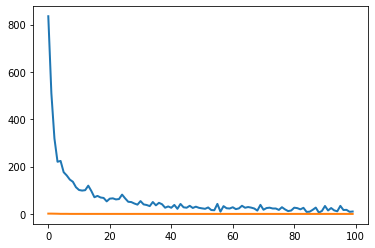

In [155]:
plt.plot(list(range(n_iter)), tot_loss_ner, linewidth=2, markersize=12)
plt.plot(list(range(n_iter)), tot_loss_textcat, linewidth=2, markersize=12)

In [156]:
for test in sentences_test[:10]:
    print(test)
    doc = custom_nlp(test)
    print("Entities in '%s'" % test)
    for ent in doc.ents:
        print(ent.label_, ent.text)
    print("Label : ",doc.cats)
    print("\n")

theresienstraße to assling
Entities in 'theresienstraße to assling'
StationStart theresienstraße
StationDest assling
Label :  {'DepartureTime': 1.8945331969888457e-09, 'FindConnection': 1.0}


connection from boltzmannstraße to kieferngarten
Entities in 'connection from boltzmannstraße to kieferngarten'
StationStart boltzmannstraße
StationDest kieferngarten
Label :  {'DepartureTime': 8.460280254141139e-10, 'FindConnection': 1.0}


connection from hauptbahnhof to odeonsplatz?
Entities in 'connection from hauptbahnhof to odeonsplatz?'
StationStart hauptbahnhof
StationDest odeonsplatz
Label :  {'DepartureTime': 9.238960152480047e-10, 'FindConnection': 1.0}


how to get from alte heide to marienplatz
Entities in 'how to get from alte heide to marienplatz'
StationStart alte heide
StationDest marienplatz
Label :  {'DepartureTime': 4.912786844002426e-10, 'FindConnection': 1.0}


how can i go from garching forschungszentrum to prinzregentenplatz
Entities in 'how can i go from garching forschun

# Notes
1. Not very clear on whether ner.add_multitask_objective(new_task) is the same as custom_nlp.add_pipe(new_task)